<a href="https://colab.research.google.com/github/syedsauda/CE888/blob/master/Assignment2/Assignment2_dataset3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Download and install scikit plot

In [1]:
pip install scikit-plot

#Importing Libraries and Functions

In [2]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import scikitplot as skplt
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler 
from sklearn.model_selection import cross_val_score

from zipfile import ZipFile

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


#Funtion to unzip file

In [0]:
def unzip(file_name):
  with ZipFile(file_name, 'r') as zip:
    zip.extractall()
    print('extracted: ',file_name)

#Downloading dataset and removing unused files

In [4]:
os.environ['KAGGLE_USERNAME'] = "syedsaud" # username from the json file
os.environ['KAGGLE_KEY'] = "7c3265f2a6cfd2e2354acf0a17b7a805" # key from the json file

!kaggle competitions download -c santander-customer-transaction-prediction #Download DATASET 1
!rm sample_submission.csv.zip
!rm test.csv.zip
!ls

 89% 111M/125M [00:01<00:00, 52.3MB/s]
100% 125M/125M [00:01<00:00, 65.9MB/s]
  0% 0.00/462k [00:00<?, ?B/s]
100% 462k/462k [00:00<00:00, 159MB/s]
 95% 119M/125M [00:01<00:00, 62.0MB/s] 
100% 125M/125M [00:01<00:00, 67.2MB/s]
sample_data  train.csv.zip


In [5]:
unzip("/content/train.csv.zip")

extracted:  /content/train.csv.zip


#Load dataset into pandas dataframe

In [6]:
orig_df_train = pd.read_csv('train.csv', header=0, sep=',', quotechar='"')
#orig_df_test = pd.read_csv('test.csv', header=0, sep=',', quotechar='"')

print(orig_df_train)
#print(orig_df_test.head())

             ID_code  target    var_0  ...  var_197  var_198  var_199
0            train_0       0   8.9255  ...   8.5635  12.7803  -1.0914
1            train_1       0  11.5006  ...   8.7889  18.3560   1.9518
2            train_2       0   8.6093  ...   8.2675  14.7222   0.3965
3            train_3       0  11.0604  ...  10.2922  17.9697  -8.9996
4            train_4       0   9.8369  ...   9.5031  17.9974  -8.8104
...              ...     ...      ...  ...      ...      ...      ...
199995  train_199995       0  11.4880  ...   8.5326  16.6660 -17.8661
199996  train_199996       0   4.9149  ...   6.7419  15.9054   0.3388
199997  train_199997       0  11.2232  ...   8.7155  13.8329   4.1995
199998  train_199998       0   9.7148  ...  10.0342  15.5289 -13.9001
199999  train_199999       0  10.8762  ...   8.1857  12.1284   0.1385

[200000 rows x 202 columns]


In [7]:
print(orig_df_train["var_0"].min())
print(orig_df_train["var_0"].max())
print(orig_df_train["var_0"].std())
print(orig_df_train["var_0"].mean())
print(orig_df_train.where(orig_df_train["var_0"]<=8.5).dropna().shape)
# print(orig_df_train.where(orig_df_train["sex"]==1).dropna().shape)
# print(orig_df_train.where(orig_df_train["sex"]==0).dropna().shape)

0.4084
20.315
3.040050870668801
10.67991425200015
(51035, 202)


In [34]:
print(orig_df_train["var_1"].min())
print(orig_df_train["var_1"].max())
print(orig_df_train["var_1"].std())
print(orig_df_train["var_1"].mean())
print(orig_df_train.where(orig_df_train["var_1"]<=-3).dropna().shape)

-15.0434
10.3768
4.050044189955011
-1.6276216894999924
(76572, 202)


Identifying the target variable and the ID varaiable

In [0]:
target_var = "target"
id_var = "ID_code"

#Detecting Covariate shift in data

Removing un-important columns (id) and output/target column(price_doc)

In [0]:
df_train = orig_df_train.where(orig_df_train["var_0"]>8.5).dropna().drop(columns=[target_var,id_var])
df_test = orig_df_train.where(orig_df_train["var_0"]<=8.5).dropna().drop(columns=[target_var,id_var])

In [30]:
print(df_train.shape)
print(df_test.shape)

(148965, 200)
(51035, 200)


In [10]:
print(df_train.shape)
print(df_test.shape)

(148965, 200)
(51035, 200)


Adding is_test column

In [0]:
df_train['is_test'] = 0
df_test['is_test'] = 1

combine dataset

In [12]:
df = pd.concat([df_train, df_test], axis = 0)
df.shape

(200000, 201)

Function to split and clasiify and show roc and auc score

In [0]:
def split_and_classify(df, feature):
  #Removing column to classify (TARGET)
  X = df.drop(columns=[feature]) 
  y = df[feature]

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True) #Randomising nad splitting before classification
  
  rfc = RandomForestClassifier()
  rfc.fit(X_train, y_train)
  y_test_score = rfc.predict_proba(X_test)
  skplt.metrics.plot_roc(y_test, y_test_score)
  plt.show()
  print('AUC score: ', round(roc_auc_score(y_true=y_test, y_score=y_test_score[:,1]), 4))
  return X,y;

In [0]:
def classify_rfc(train_df, test_df, feature):

  X_train = train_df.drop(columns=[feature])
  y_train = train_df[feature]

  X_test = test_df.drop(columns=[feature])
  y_test = test_df[feature]
  
  rfc = RandomForestClassifier()
  rfc.fit(X_train, y_train)
  y_test_score = rfc.predict_proba(X_test)
  skplt.metrics.plot_roc(y_test, y_test_score)
  plt.show()
  print('AUC score: ', round(roc_auc_score(y_true=y_test, y_score=y_test_score[:,1]), 4))

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


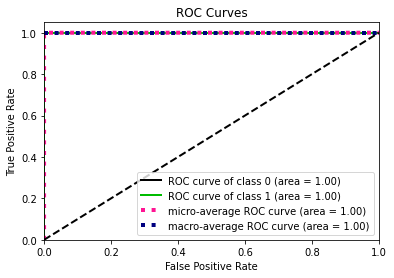

AUC score:  1.0


In [14]:
X,y = split_and_classify(df,"is_test")

Finding features causing covariate shift

In [0]:
drop_list = []
model = RandomForestClassifier(n_estimators = 50, max_depth = 5,min_samples_leaf = 5)
for i in X.columns:
    score = cross_val_score(model,pd.DataFrame(X[i]),y,cv=2,scoring='roc_auc')
    if (np.mean(score) > 0.8):
        drop_list.append(i)
        print(i,np.mean(score))

In [16]:
print(drop_list)

['var_0']


Removing features that cause shift

In [17]:
df.drop(columns=["var_0"],inplace=True)
df.shape

(200000, 200)

In [0]:
def histo(df_test, df_train, feature):
  print("Histogram of dataset on '",feature,"'")
  histo = sns.distplot(df_test[[feature]].values.T[0], color="blue", kde=False, label="Testing data")
  histo = sns.distplot(df_train[[feature]].values.T[0], color="red", kde=False, label="Training data")
  legend = histo.legend()

In [0]:
df_orig = orig_df_train.drop(columns=[target_var,id_var])
normalized_test=(df_test-df_orig.min())/(df_orig.max()-df_orig.min())
normalized_train=(df_train-df_orig.min())/(df_orig.max()-df_orig.min())

Histogram of dataset on ' var_0 '


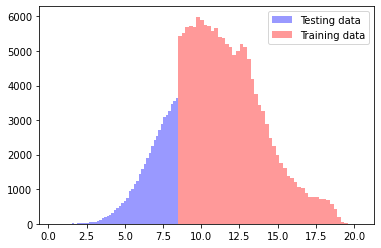

In [20]:
histo(df_test, df_train,"var_0")

Histogram of dataset on ' var_0 '


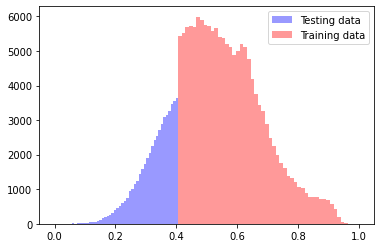

In [21]:
histo(normalized_test, normalized_train,"var_0")

splitting and classifying with removed features

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


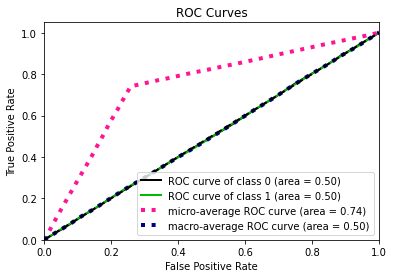

AUC score:  0.4997


In [22]:
unused,unused2 = split_and_classify(df,"is_test")

Trainging orignal dataset on target variable and checking performance without co-variate shift

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


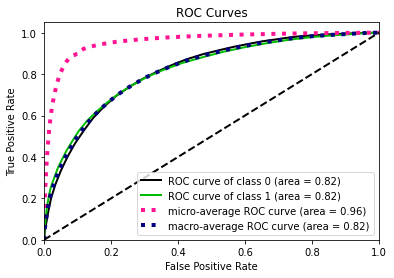

AUC score:  0.8183


In [23]:
df_no_covariate = orig_df_train.drop(columns=[id_var,"var_0"])
unused,unused2 = split_and_classify(df_no_covariate,"target")

In [25]:
df_no_covariate.shape

(200000, 200)

# TODO: CHECK PERFORMANCE WITH CO-VARIATE SHIFT

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


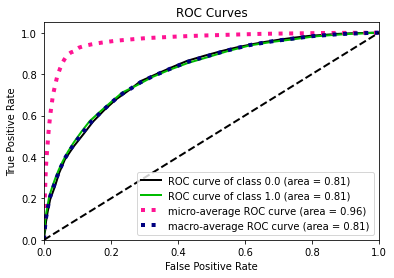

AUC score:  0.8126


In [37]:
df_train = orig_df_train.where(orig_df_train["var_0"]>8.5).dropna().drop(columns=[id_var])
df_test = orig_df_train.where(orig_df_train["var_0"]<=8.5).dropna().drop(columns=[id_var])
classify_rfc(df_train,df_test,"target")